In [100]:
import pandas as pd
import numpy as np
from ast import literal_eval
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import os
from openai import AzureOpenAI

import openai
from dotenv import load_dotenv 

from typing import Any, Optional, Union
from tenacity import (
    retry,
    retry_if_exception_type,
    stop_after_attempt,
    wait_random_exponential,
)

In [98]:
from azure.identity import AzureCliCredential, ChainedTokenCredential, ManagedIdentityCredential, EnvironmentCredential

# Define strategy which potential authentication methods should be tried to gain an access token
credential = ChainedTokenCredential(ManagedIdentityCredential(), EnvironmentCredential(), AzureCliCredential())
access_token = credential.get_token("https://cognitiveservices.azure.com/.default")

In [99]:
load_dotenv()  

#openai.api_type = "azure"
#openai.api_key = os.getenv("AZURE_OPENAI_API_KEY")  
openai.api_key = access_token.token

openai.api_type = 'azure_ad'
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")  
openai.api_version = os.getenv("AZURE_OPENAI_API_VERSION") 
model: str = "text-embedding-3-small" 

In [101]:
train_df = pd.read_csv(".data/Training.csv")
validation_df = pd.read_csv(".data/Validation.csv")

In [102]:
validation_df.head()

,Question,Topic
0,What is escrow?,Servicing
1,Provide details about Forbearance loss mit ret...,Servicing
2,What all liquidation options offered for loss ...,Servicing
3,Do I need a Divorce Decree to evaluate loss mi...,Servicing
4,give me the guidelines for Transferring Calls ...,Servicing


In [103]:
client = AzureOpenAI(
  api_key = os.getenv("AZURE_OPENAI_API_KEY"),  
  api_version = "2024-02-01",
  azure_endpoint =os.getenv("AZURE_OPENAI_ENDPOINT") 
)

def get_embeddings(client, input_text, model_name):
    response = client.embeddings.create(
        input = input_text,
        model= model_name  # model = "deployment_name".
        )
    return response.model_dump()['data'][0]['embedding']

def process_dataframe(dataframe):
    embedding_models = ["text-embedding-ada-002","text-embedding-3-small", "text-embedding-3-large"]

    for embedding_model in embedding_models:
        dataframe[embedding_model] = dataframe['Question'].apply(lambda x: get_embeddings(client,x,embedding_model))
    
    return dataframe

In [104]:
train_df = process_dataframe(train_df)
validation_df = process_dataframe(validation_df)

In [105]:
type(train_df['text-embedding-ada-002'][0])

list

In [106]:
# train random forest classifier
clf = RandomForestClassifier(n_estimators=1000,random_state=14)
clf.fit(list(train_df['text-embedding-ada-002'].values), train_df['Topic'])
preds = clf.predict(list(validation_df['text-embedding-ada-002'].values))
probas = clf.predict_proba(list(validation_df['text-embedding-ada-002'].values))

report = classification_report(validation_df['Topic'], preds)
print(report)

               precision    recall  f1-score   support

           HR       1.00      0.90      0.95        10
           IT       0.91      1.00      0.95        10
    Servicing       1.00      1.00      1.00        10
ServicingData       1.00      1.00      1.00         9
      Welcome       1.00      1.00      1.00         4

     accuracy                           0.98        43
    macro avg       0.98      0.98      0.98        43
 weighted avg       0.98      0.98      0.98        43



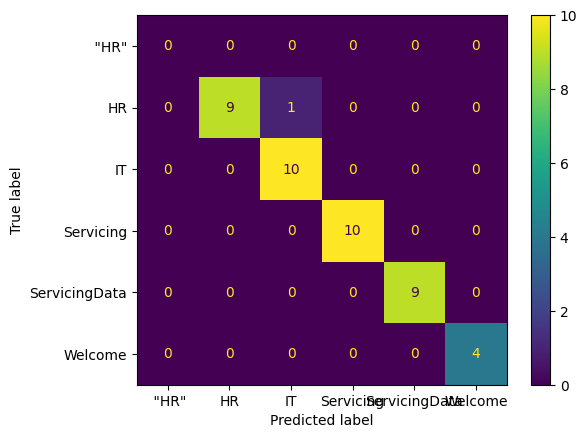

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(validation_df['Topic'], preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [108]:
validation_df['Predicted'] = preds
validation_df[['Question','Topic','Predicted']]

,Question,Topic,Predicted
0,What is escrow?,Servicing,Servicing
1,Provide details about Forbearance loss mit ret...,Servicing,Servicing
2,What all liquidation options offered for loss ...,Servicing,Servicing
3,Do I need a Divorce Decree to evaluate loss mi...,Servicing,Servicing
4,give me the guidelines for Transferring Calls ...,Servicing,Servicing
5,What is the process for reviewing a VA loan fo...,Servicing,Servicing
6,How do I handle a REO account??,Servicing,Servicing
7,How do I handle an account that is in foreclos...,Servicing,Servicing
8,How do I handle an account where the homeowner...,Servicing,Servicing
9,What is motion for relief?,Servicing,Servicing
